In [66]:
# Import all of the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
%matplotlib inline 

from functools import reduce

import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#
import seaborn as sns
sns.set_style('whitegrid')

# sklearn 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [74]:
# Upload datasets
data_customers = pd.read_csv('olist_customers_dataset.csv')
data_sellers = pd.read_csv('olist_sellers_dataset.csv')
data_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
data_order_items = pd.read_csv('olist_order_items_dataset.csv')
data_products = pd.read_csv('olist_products_dataset.csv')
data_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
data_translation = pd.read_csv('product_category_name_translation.csv')
data_orders = pd.read_csv('olist_orders_dataset.csv')
data_order_payments = pd.read_csv('olist_order_payments_dataset.csv')

In [109]:
data_customers[['customer_id', 'customer_unique_id']]

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e


In [75]:
#list with datasets with PK and FK 'order_id'
ordersList = [data_orders, data_order_items]

#merge, join multiple datasets with the same FK:
data = reduce(lambda data1, data2: pd.merge(data1, data2, on='order_id', how='left'), ordersList)

data = pd.merge(data, data_products, on='product_id', how='outer')

data = pd.merge(data, data_sellers, on='seller_id', how='outer')

#merge final data with the same FK (customer_id):
data = pd.merge(data, data_customers, on='customer_id', how='outer')

In [76]:
data = data.merge(data_translation, on='product_category_name').drop('product_category_name', axis=1)

In [77]:
data.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,9350.0,maua,SP,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,9350.0,maua,SP,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,9350.0,maua,SP,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,housewares
4,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,2.0,be03d93320192443b8fa24c0ca6ead98,...,16.0,13.0,9350.0,maua,SP,7a1de9bde89aedca8c5fbad489c5571c,1315,sao paulo,SP,housewares


In [78]:
# Convert objects date columns to dates desconsidering the errors
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for column in dateColumns:
    data[column] = pd.to_datetime(data[column], errors='coerce')

## EDA- Exploratory Data Analysis

- Created a single dataset for OLAP by denormalization in order to analyze with more performance.
- Lets look into the dataset


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111023 entries, 0 to 111022
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111023 non-null  object        
 1   customer_id                    111023 non-null  object        
 2   order_status                   111023 non-null  object        
 3   order_purchase_timestamp       111023 non-null  datetime64[ns]
 4   order_approved_at              111009 non-null  datetime64[ns]
 5   order_delivered_carrier_date   109868 non-null  datetime64[ns]
 6   order_delivered_customer_date  108637 non-null  datetime64[ns]
 7   order_estimated_delivery_date  111023 non-null  datetime64[ns]
 8   order_item_id                  111023 non-null  float64       
 9   product_id                     111023 non-null  object        
 10  seller_id                      111023 non-null  object        
 11  

In [80]:
data.loc[(data.order_delivered_customer_date.isna())&((data.order_status == 'shipped')) ]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
147,fc1095da158f0fc66f917a4f7a257183,2996ce648d9a96c6db31d26d4fcf4824,shipped,2018-03-29 13:03:45,2018-03-30 03:26:51,2018-04-03 17:58:40,NaT,2018-04-17,1.0,c20a3f598c16d77249da67e81caa8317,...,18.0,12.0,4782.0,sao paulo,SP,321f74bf94aed1a80cbbeae7469e1333,12280,cacapava,SP,housewares
162,29446d5a7212cd18dec57e1ba28c2dee,962700004d45a72f0fed2b8a3c447e0f,shipped,2018-08-02 20:17:15,2018-08-02 21:00:08,2018-08-03 08:38:00,NaT,2018-08-21,1.0,c20a3f598c16d77249da67e81caa8317,...,18.0,12.0,4782.0,sao paulo,SP,69446a8db60fc5dea48ea9ec3478f36a,21011,rio de janeiro,RJ,housewares
230,5e6f7229aec06e67732033777ee84816,11787df0ce15c1f8f9810e452fdf3925,shipped,2018-08-17 11:55:11,2018-08-17 14:27:13,2018-08-20 09:16:00,NaT,2018-09-04,1.0,928e52a9ad53a294fdcc91bcf59d1751,...,60.0,20.0,4782.0,sao paulo,SP,f65bf2a31e41b9fbbc1c14056b762f08,14640,morro agudo,SP,housewares
242,d3643399509c4df2d897ac4321bd6339,0d411936b4da908edc171b0ab99589c5,shipped,2018-03-27 16:28:50,2018-03-28 15:47:12,2018-03-29 23:14:19,NaT,2018-04-20,1.0,7c55ea4aea1acf1ce11440010f5aa298,...,50.0,20.0,4782.0,sao paulo,SP,9e10a42bf2dbabb0454ee38fb1baf890,57041,maceio,AL,housewares
255,78c0a28679d359bd04124988a2e04bac,5a2a027db93ee7ca12f71003b0fd98b1,shipped,2018-04-24 22:14:06,2018-04-24 22:32:55,2018-04-26 10:13:00,NaT,2018-05-24,1.0,7c55ea4aea1acf1ce11440010f5aa298,...,50.0,20.0,4782.0,sao paulo,SP,d7e2da50edc0e56f6cd33d8b667a2899,62920,quixere,CE,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110541,e658e8dc29fc5581482829dbcc127aac,be8bdf1e52f69c9b1759f5b44cfb44f3,shipped,2017-09-11 22:57:29,2017-09-13 03:26:15,2017-09-18 22:12:17,NaT,2017-10-03,1.0,1de74e63d630007567726953a4eb2b36,...,10.0,25.0,3017.0,sao paulo,SP,ffa652b0cdf8bba29664149a9e579134,78142,varzea grande,MT,fashion_underwear_beach
110592,f8a0c2f75253cacddb95753652794c0f,ba3e4b522140831766d5edca1609aa0e,shipped,2017-04-06 23:05:31,2017-04-06 23:22:38,2017-04-10 11:37:46,NaT,2017-05-10,1.0,7932fcce65e2aee84d6feb4a288f9cb9,...,2.0,11.0,2929.0,sao paulo,SP,8493b1d5900abad27591600df2eea383,46500,macaubas,BA,fashion_underwear_beach
110656,bb82d1c94323c38a3d8124414a6a5ca5,3aac1b9595d8ad08680f3d00d5afc432,shipped,2017-07-30 17:09:00,2017-08-02 02:34:10,2017-08-07 12:32:08,NaT,2017-08-30,1.0,e485be8a88ca64e497e88b16af6cc11d,...,2.0,14.0,74560.0,goiania,GO,0c6ea2a59dd585779e9b25d3df3ed41b,23092,rio de janeiro,RJ,dvds_blu_ray
110879,b812ed76702a2ef99a79eb6a32e410c7,ab874cd4e96cb693eda2458dfe17bd29,shipped,2018-05-05 18:27:06,2018-05-07 08:52:09,2018-05-17 12:25:00,NaT,2018-06-04,1.0,74f6a88474993377506706e383f98302,...,13.0,30.0,86030.0,londrina,PR,5f871d65feed8b547abb81cd6e688ad5,38421,uberlandia,MG,cine_photo


In [81]:
# Looking into the quantity of NaN which can effect the performance of our analysis 

data_miss = pd.concat([data.isna().sum().sort_values(ascending = False),
                       ((data.isna().sum()/data.isna().count())*100).sort_values(ascending = False),
                       data.dtypes], axis=1, keys=['Total_Missing', 'Missing_%', 'Type'])

data_miss[data_miss['Total_Missing'] > 0]

,Total_Missing,Missing_%,Type
order_delivered_customer_date,2386,2.149104,datetime64[ns]
order_delivered_carrier_date,1155,1.040325,datetime64[ns]
order_approved_at,14,0.012610,datetime64[ns]
product_width_cm,1,0.000901,float64
product_height_cm,1,0.000901,float64
product_length_cm,1,0.000901,float64
product_weight_g,1,0.000901,float64


As discussed in the description of the data set, the data model was original had different relationships. A single purchase can contain multiple products, multiple forms of payments and/or multiple sellers. The order_id is not a primary key. We need to calculate averages considering the value of unique sales.  

In [82]:
totalOrders = data_orders.order_id.nunique()

print('Summary of Brazilian E-Commerce')
print('Avg Price:', data.price.sum()/ totalOrders)
print('Avg Quantity of Products by Order:', data.order_item_id.sum()/ totalOrders)
print('Avg Freight Price:', data.freight_value.sum()/ totalOrders)
print('---------------------------------------------------------------------------')
print('Unique Customer :', data.customer_unique_id.nunique())
print('Unique Customer Cities:', data.customer_city.nunique())
print('Unique Customer States:', data.customer_state.nunique())
print('Unique Seller States:', data.seller_state.nunique())
print('---------------------------------------------------------------------------')
print('Total Revenue:', data.price.sum())
print('Total Order Quantity:', totalOrders)

Summary of Brazilian E-Commerce
Avg Price: 134.8195808569906
Avg Quantity of Products by Order: 1.3377882362405848
Avg Freight Price: 22.357944912058407
---------------------------------------------------------------------------
Unique Customer : 94088
Unique Customer Cities: 4095
Unique Customer States: 27
Unique Seller States: 23
---------------------------------------------------------------------------
Total Revenue: 13406593.940000001
Total Order Quantity: 99441


count    97256.000000
mean       137.848502
std        210.515926
min          0.850000
25%         45.900000
50%         86.800000
75%        149.900000
max      13440.000000
Name: price, dtype: float64
count    111023.000000
mean        120.755104
std         183.372746
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


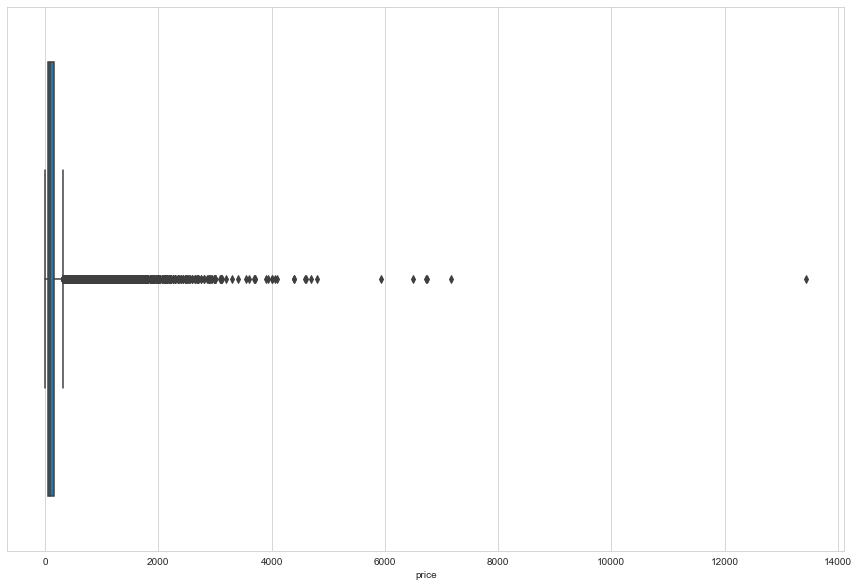

In [83]:
#Evaluating price distribution
plt.figure(figsize=(15,10))
sns.boxplot(x=data.groupby('order_id')['price'].sum())
print(data.groupby('order_id')['price'].sum().describe())
print(data['price'].describe())

In [84]:
print(data.groupby('order_id')['price'].sum().sort_values(ascending=False).head(10))

order_id
03caa2c082116e1d31e67e9ae3700499    13440.0
736e1922ae60d0d6a89247b851902527     7160.0
0812eb902a67711a1cb742b3cdaa65ae     6735.0
fefacc66af859508bf1a7934eab1e97f     6729.0
f5136e38d1a14a4dbd87dff67da82701     6499.0
2cc9089445046817a7539d90805e6e5a     5934.6
a96610ab360d42a2e5335a3998b4718a     4799.0
199af31afc78c699f0dbf71fb178d4d4     4690.0
b4c4b76c642808cbe472a32b86cddc95     4599.9
8dbc85d1447242f3b127dda390d56e19     4590.0
Name: price, dtype: float64


In [85]:
data.loc[data['order_id']=='03caa2c082116e1d31e67e9ae3700499']['price']

104818    1680.0
104819    1680.0
104820    1680.0
104821    1680.0
104822    1680.0
104823    1680.0
104824    1680.0
104825    1680.0
Name: price, dtype: float64

In [86]:
# In future work I would like to perform similar analysis but by binning through prices and compared the differences btw high ticket products vs smaller

<AxesSubplot:title={'center':'Total Price By State (R$)'}, xlabel='customer_state', ylabel='price'>

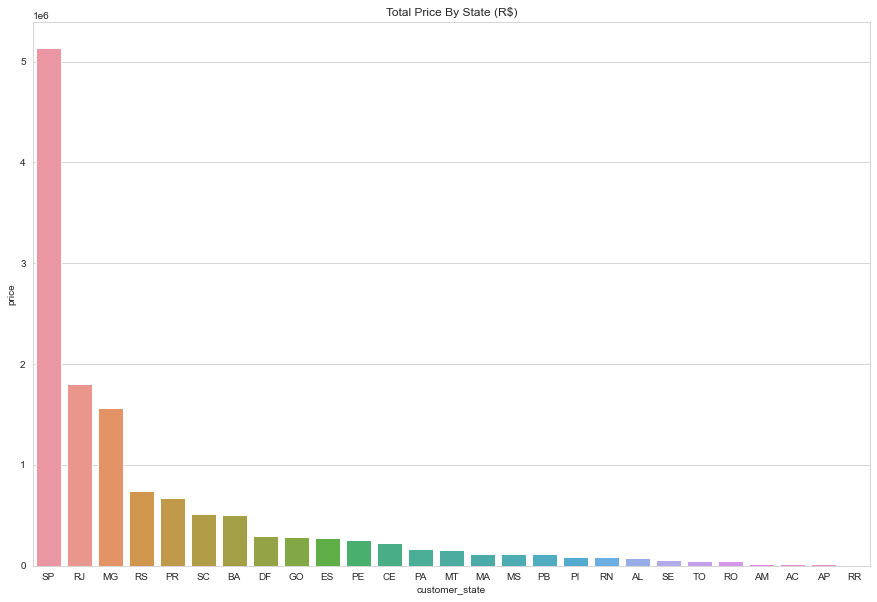

In [87]:
# Total Price by State
plt.figure(figsize=(15,10))
plt.title('Total Price By State (R$)')
sns.barplot(x=data.groupby('customer_state')['price'].sum().sort_values(ascending=False).index,
            y=data.groupby('customer_state')['price'].sum().sort_values(ascending=False))

<AxesSubplot:title={'center':'Total Seller Counts By State'}, xlabel='seller_state', ylabel='order_id'>

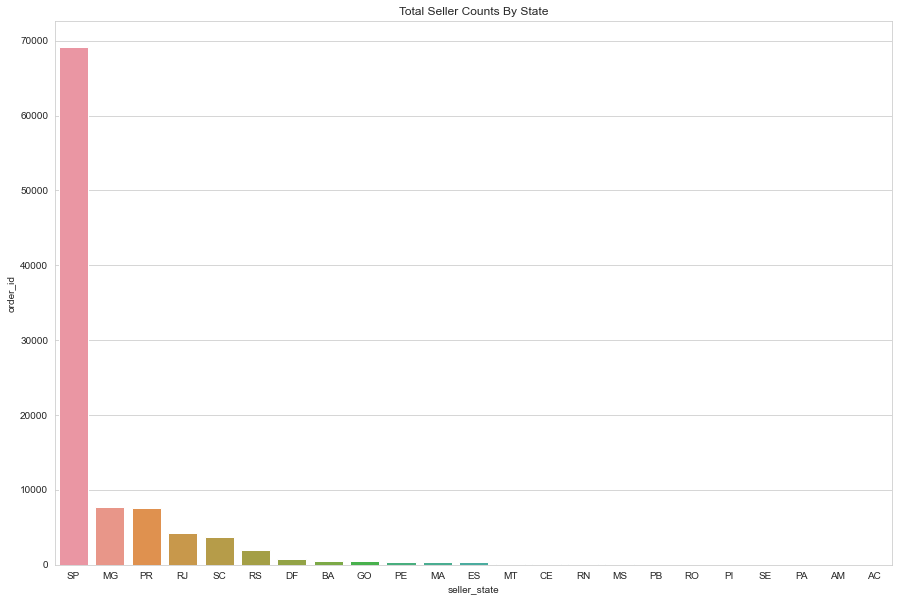

In [88]:
# Total Price by State
plt.figure(figsize=(15,10))
plt.title('Total Seller Counts By State')
sns.barplot(x=data.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False).index,
            y=data.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False))

Based on the average freight value by State we can begin to understand why the State SP has a high number of sellers. With the lowest freight value you can expect more return by reducing your delivery cost. 

<AxesSubplot:title={'center':'Average freight value in R$ by State of the Customer'}, xlabel='customer_state'>

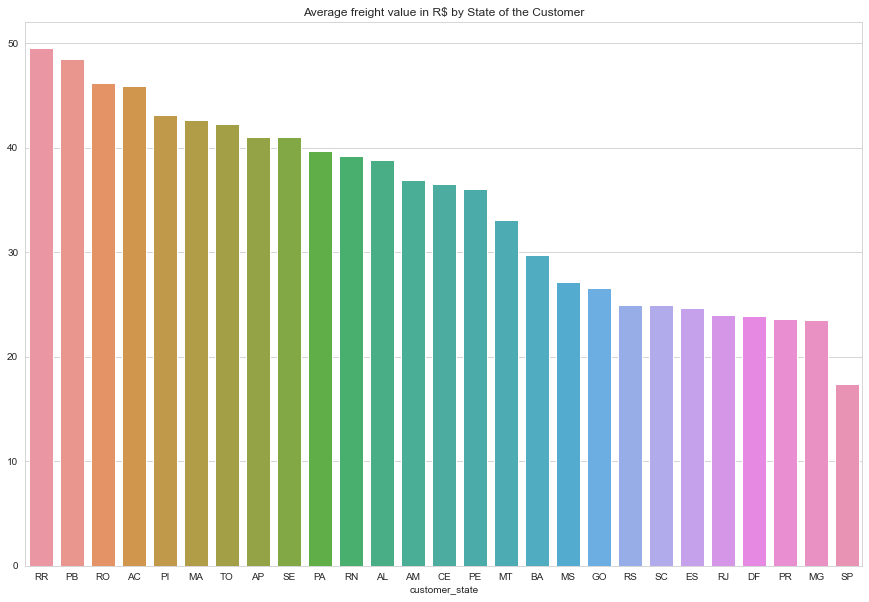

In [89]:
freightAvgState = (data.groupby('customer_state')['freight_value'].sum() /data.groupby('customer_state')['order_id'].nunique()).sort_values(ascending=False)

plt.figure(figsize=(15,10))
plt.title('Average freight value in R$ by State of the Customer')
sns.barplot(x=freightAvgState.index, y=freightAvgState)

#### Product & Reviews Categories

## Data Science
- Clustering
- Clasification
- Time Series

### Clustering - RFM technique
RFM(recency, frequency, monetary) analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of thier recent transactions to ID the best customers and perform targeted marketing campaigns.

In [90]:
# Feature creation

# Day of the week feature creation
data['day_of_wk'] = data.order_approved_at.dt.weekday

# Last order date(Recency)
last_order = data.order_purchase_timestamp.max()
data['recency'] = ((last_order - data['order_purchase_timestamp']).dt.days)

# Frequency of purchases feature creation - how many unique orders does each customer have(Frequency)
data['total_orders'] = data.groupby('customer_unique_id')['order_id'].transform('nunique')

# Total Spent feature creation(Monetaray)
data['total_spent'] = data.groupby('customer_unique_id')['price'].transform('sum')

In [91]:
clusteringData = data[['customer_unique_id', 'total_orders', 'total_spent', 'recency']]

#group by the id and show the total orders and total spent, using the minimum recency when there are more than 2 orders.
clusteringData = clusteringData.loc[clusteringData.groupby('customer_unique_id').recency.idxmin()] #.set_index('customer_unique_id')

clusteringData

,customer_unique_id,total_orders,total_spent,recency
85154,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115
46123,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118
79231,0000f46a3911fa3c0805444483337064,1,69.00,541
74925,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325
73751,0004aac84e0df4da2b147fca70cf8255,1,180.00,292
...,...,...,...,...
43534,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00,451
8568,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,266
54682,ffff371b4d645b6ecea244b27531430a,1,89.90,572
56867,ffff5962728ec6157033ef9805bacc48,1,115.00,123


Old Shape:  (94088, 4)
Lower bound: -113.81874999999994
Upper bound: 317.4312499999999
New Shape:  (94088, 4)


<AxesSubplot:title={'center':'Total Spent features without outliers'}, xlabel='total_spent'>

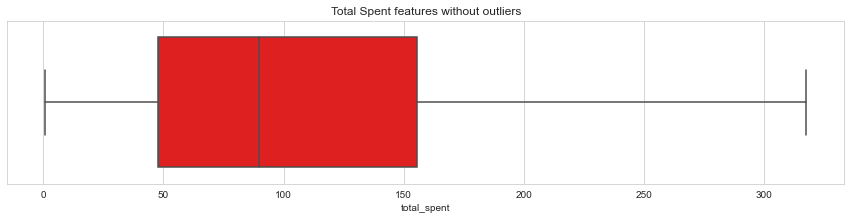

In [92]:
#Detect the outliers using IQR technique

q1 = clusteringData['total_spent'].quantile(0.25)
q3 = clusteringData['total_spent'].quantile(0.75)
iqr = q3 - q1
 
print("Old Shape: ", clusteringData.shape)
 
#Upper and Lower Limits
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print("Lower bound:", lower)
print("Upper bound:", upper)
 
# new_df = data[data['Income'] > upper]
# new_df = data[data['Income']  < lower]

# Capping (above or below certain limit, all Incomes will be the same)

clusteringData['total_spent'] = np.where(clusteringData['total_spent'] > upper, upper, 
                               np.where(clusteringData['total_spent'] < lower, lower,
                               clusteringData['total_spent']))

print("New Shape: ", clusteringData.shape)

#distribution of Income without the greater outliers
plt.figure(figsize=(15,3))
plt.title('Total Spent features without outliers')
sns.boxplot(x=clusteringData['total_spent'], color='red')

In [93]:
#Function to process individual variables, calculate the elbow and Silhouette Scores and cluster by the feature.

def cluster_individual(data, column, invert=False):
    data = data
    columnName = str(column)
    className = "class_" + columnName
    X = data[column]
    X = pd.DataFrame(X)
    

    print('Results for clustering the feature:', columnName)
    

    # n_clusters = 3

    #Define the model using Elbow method to show best K value 
    kmeans_kwargs = {
        "n_clusters": 5,
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 1,
    }


#--------> Sort Clusters by yasirroni
#--------> https://github.com/yasirroni/sorted_cluster
#--------> Copyright (c) 2020 Muhammad Yasirroni

    def sorted_cluster(x, model=None):
        if model == None:
            model = KMeans()
        model = sorted_cluster_centers_(model, x)
        model = sorted_labels_(model, x)
        return model

    def sorted_cluster_centers_(model, x):
        model.fit(x)
        new_centroids = []
        magnitude = []
        for center in model.cluster_centers_:
            magnitude.append(np.sqrt(center.dot(center)))
        idx_argsort = np.argsort(magnitude)
        model.cluster_centers_ = model.cluster_centers_[idx_argsort]
        return model

    def sorted_labels_(sorted_model, x):
        sorted_model.labels_ = sorted_model.predict(x)
        return sorted_model

#--------> Sort Clusters by yasirroni

    # Final model 
    km = KMeans(**kmeans_kwargs).fit(X)

    # assign a cluster to each
    # X[className] = km.fit_predict(X)
    cluster = sorted_cluster(X, km)
    X[className] = cluster.predict(X)



    #------Plot results of the clustering using the above K
    plt.figure(figsize=(15,3))
    plt.title('Results of clustering')

    sns.scatterplot(x=X[columnName], y=X.index, hue=X[className], s=30)
    
    #Append the clustering to the original DataSet
    data[className] = X[className] + 1

    if invert:
        data[className] = data[className].map({5:1,
                                            4:2,
                                            3:3,
                                            2:4,
                                            1:5})

    # return data

Results for clustering the feature: recency


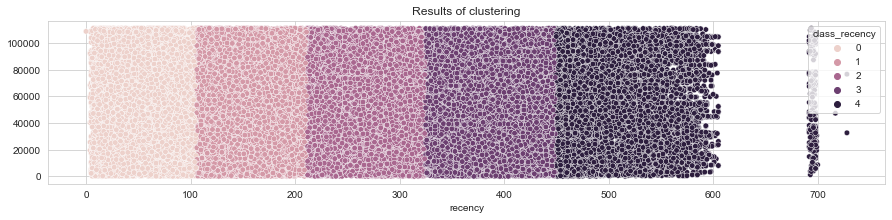

In [94]:
cluster_individual(clusteringData, 'recency', invert=True)

Results for clustering the feature: total_spent


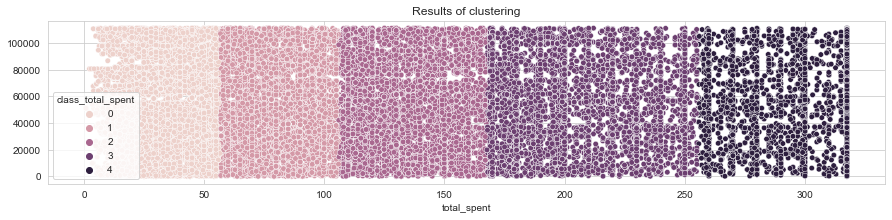

In [95]:
cluster_individual(clusteringData, 'total_spent')

Results for clustering the feature: total_orders


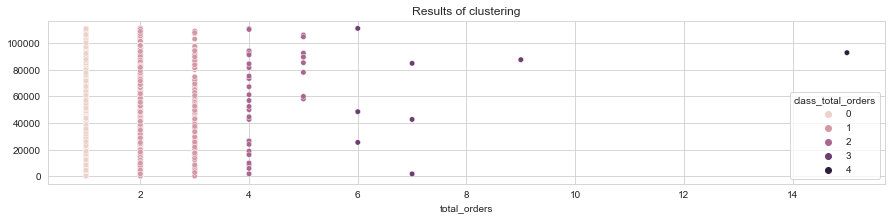

In [96]:
cluster_individual(clusteringData, 'total_orders')

In [97]:
#RFM table

def segmentCustomers(data):
    fmMean = (data['class_total_orders'] + data['class_total_spent']) / 2
    
    if (data['class_recency'] >= 4) and (fmMean >= 4):
        return 'Champions'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 5) and (fmMean >= 3 and fmMean <= 5):
        return 'Loyal Customers'
    if (data['class_recency'] >= 3 and data['class_recency'] <= 5) and (fmMean >= 1 and fmMean <= 3):
        return 'Potential Loyslist'
    if (data['class_recency'] >= 4 and data['class_recency'] <= 5) and (fmMean >= 0 and fmMean <= 1):
        return 'New Customers'
    if (data['class_recency'] >= 3 and data['class_recency'] <= 4) and (fmMean >= 0 and fmMean <= 1):
        return 'Promising'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 3) and (fmMean >= 2 and fmMean <= 3):
        return 'Customer Needing Attention'
    if (data['class_recency'] >= 2 and data['class_recency'] <= 3) and (fmMean >= 0 and fmMean <= 2):
        return 'About to Sleep'
    if (data['class_recency'] >= 0 and data['class_recency'] <= 2) and (fmMean >= 2 and fmMean <= 5):
        return 'At Risk'
    if (data['class_recency'] >= 0 and data['class_recency'] <= 1) and (fmMean >= 4 and fmMean <= 5):
        return "Can't Lose Then"
    if (data['class_recency'] >= 1 and data['class_recency'] <= 2) and (fmMean >= 1 and fmMean <= 2):
        return 'Hibernating'
    return 'Lost'


clusteringData['customerSegment'] = clusteringData.apply(segmentCustomers, axis=1)

clusteringData['customerSegment']

85154    Potential Loyslist
46123    Potential Loyslist
79231           Hibernating
74925        About to Sleep
73751    Potential Loyslist
                ...        
43534               At Risk
8568     Potential Loyslist
54682           Hibernating
56867    Potential Loyslist
35711           Hibernating
Name: customerSegment, Length: 94088, dtype: object

In [98]:
clusteringData.head()

,customer_unique_id,total_orders,total_spent,recency,class_recency,class_total_spent,class_total_orders,customerSegment
85154,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,4,3,1,Potential Loyslist
46123,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118,4,1,1,Potential Loyslist
79231,0000f46a3911fa3c0805444483337064,1,69.00,541,1,2,1,Hibernating
74925,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325,2,1,1,About to Sleep
73751,0004aac84e0df4da2b147fca70cf8255,1,180.00,292,3,4,1,Potential Loyslist


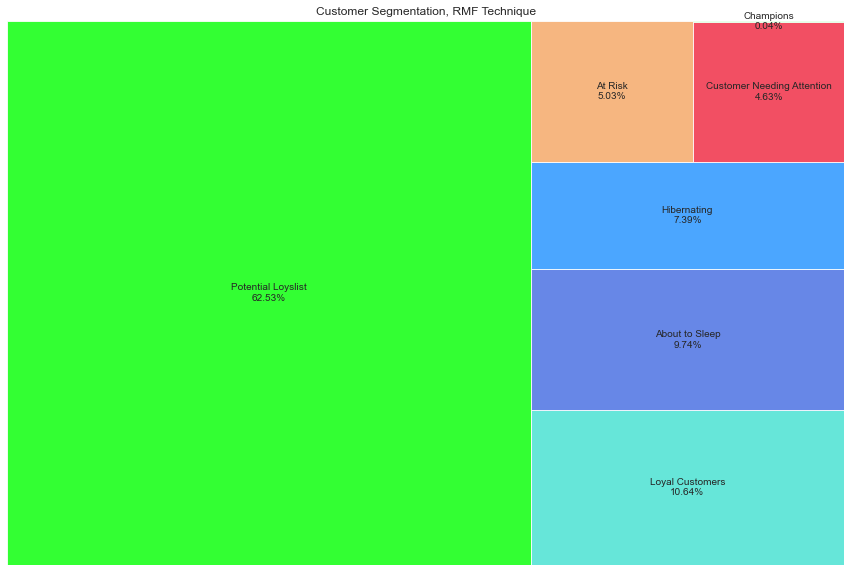

In [99]:
import squarify
sns.set_style(style="whitegrid") # set seaborn plot style
cat= clusteringData['customerSegment'].value_counts(normalize=True)*100# proportions of the categories
labels = (cat.index[i] + "\n" + str(round(cat[i], 2)) + "%" for i in range(len(cat)))
colors=['lime','turquoise','royalblue','dodgerblue','sandybrown','#ef233c']

plt.figure(figsize=(15,10))
squarify.plot(sizes=cat, label=labels, alpha=0.8,color=colors).set(title='Customer Segmentation, RMF Technique')
plt.axis('off')
plt.show()
#plt.savefig('Customer_Seg.png')

### Classification: Prediciting Customer Satisfaction

In [118]:
# Downloading data 

order_list = pd.read_csv('olist_public_dataset_v2.csv/olist_public_dataset_v2.csv')

# converting to datetime
order_list['order_purchase_timestamp'] = pd.to_datetime(order_list.order_purchase_timestamp)
order_list['order_aproved_at'] = pd.to_datetime(order_list.order_aproved_at).dt.date  
order_list['order_estimated_delivery_date'] = pd.to_datetime(order_list.order_estimated_delivery_date).dt.date  
order_list['order_delivered_customer_date'] = pd.to_datetime(order_list.order_delivered_customer_date).dt.date 

# Merge translation for category names
translation = pd.read_csv('product_category_name_translation.csv')

order_list = order_list.merge(translation, on='product_category_name').drop('product_category_name', axis=1)

order_list.head(3)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01,2017-03-15,2017-02-06,...,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00,health_beauty
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,2018-04-17 13:25:36,2018-04-18,2018-05-10,2018-04-27,...,405,2,190d9562bfbe9d3ed876c2ac6f2f5894,e98077a0d199a25a40eab3b14cc230d4,5,NaN,NaN,2018-04-28 00:00:00.000000,2018-04-29 21:07:53+00:00,health_beauty
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,2018-02-18 12:41:01,2018-02-18,2018-03-14,2018-03-03,...,1665,1,5858f45c20fde7d7e49af37a2166635a,8a723730400b508cbf47fbef4a76ec8e,5,NaN,muito bom cabelo fica lisinho,2018-03-04 00:00:00.000000,2018-03-07 02:53:50+00:00,health_beauty


In [119]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100000 non-null  object        
 1   order_status                   100000 non-null  object        
 2   order_products_value           100000 non-null  float64       
 3   order_freight_value            100000 non-null  float64       
 4   order_items_qty                100000 non-null  int64         
 5   order_sellers_qty              100000 non-null  int64         
 6   order_purchase_timestamp       100000 non-null  datetime64[ns]
 7   order_aproved_at               99982 non-null   object        
 8   order_estimated_delivery_date  100000 non-null  object        
 9   order_delivered_customer_date  97595 non-null   object        
 10  customer_id                    100000 non-null  object        
 11  c

For the sake of testing our Hypothesis we will remove written reviews made by the customer.

In [128]:
#Removing columns that are repetative and do not add unique value to model.
#Removing written reviews as it will not help us create a model that will predict customer satisfaction.
order_list = order_list.drop(['customer_city', 'customer_zip_code_prefix',
                              'product_id',
                              'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp' ], axis=1)

In [129]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100000 non-null  object        
 1   order_status                   100000 non-null  object        
 2   order_products_value           100000 non-null  float64       
 3   order_freight_value            100000 non-null  float64       
 4   order_items_qty                100000 non-null  int64         
 5   order_sellers_qty              100000 non-null  int64         
 6   order_purchase_timestamp       100000 non-null  datetime64[ns]
 7   order_aproved_at               99982 non-null   object        
 8   order_estimated_delivery_date  100000 non-null  object        
 9   order_delivered_customer_date  97595 non-null   object        
 10  customer_id                    100000 non-null  object        
 11  c

In [130]:
order_list.dropna(inplace=True)
order_list.head(10)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,review_score,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01,2017-03-15,2017-02-06,297dcf281305aabfee256d313076af2b,PR,51,625,1,5,health_beauty
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,2018-04-17 13:25:36,2018-04-18,2018-05-10,2018-04-27,5161d5feec98ade754f67746caf8e0c9,DF,51,405,2,5,health_beauty
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,2018-02-18 12:41:01,2018-02-18,2018-03-14,2018-03-03,f19376e0c54da9409485f7ef9556d367,MG,38,1665,1,5,health_beauty
3,cf71b9b6b7ed12d72f541b0420023f19,delivered,79.99,10.94,1,1,2018-05-09 23:33:28,2018-05-11,2018-05-24,2018-05-17,12698ad9da6b62003811594de0ae297e,ES,59,492,3,4,health_beauty
4,93ef9253c47e7dfc633c01f728488cb1,delivered,58.99,11.73,1,1,2017-10-26 09:07:04,2017-10-27,2017-11-09,2017-10-31,ba21875fac3c41b6ac433113cf862e55,SP,59,492,2,4,health_beauty
5,35bc592a16d6706d14d29f07ed1d13c1,delivered,639.00,21.40,1,1,2018-08-11 15:41:42,2018-08-11,2018-08-28,2018-08-22,b88a511344b8b49a02bca030ace61ef6,RJ,59,2141,1,5,health_beauty
6,e7769dad49f530a8ef12ff975719c27f,delivered,23.99,7.78,1,1,2017-10-18 20:26:10,2017-10-18,2017-11-03,2017-10-23,d428a3e61ed2bee543429c4e0d1c8ca7,SP,48,575,1,5,health_beauty
7,bf84e0afb917b54c4a95b9497c4881fb,delivered,219.00,15.70,1,1,2017-03-04 14:15:02,2017-03-04,2017-03-27,2017-03-13,1d5681e374f62ccfd969981d6c088d73,SP,42,1607,3,5,health_beauty
8,288cd0aca6f66df79aab71d94c1caad7,delivered,29.90,12.87,1,1,2018-07-15 22:07:27,2018-07-17,2018-07-31,2018-07-20,808b9e5258ac0caf36a2c630807180a1,SP,58,391,1,4,health_beauty
9,38f84a21226e448e6ca37b3c45144994,delivered,55.90,11.73,1,1,2018-02-09 13:46:39,2018-02-09,2018-02-23,2018-02-16,e91d6e2c6d965a4d07ff782ce5bde6db,SP,55,1297,1,5,health_beauty


In [131]:
order_list = order_list.reset_index(drop=True)

In [132]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97578 entries, 0 to 97577
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97578 non-null  object        
 1   order_status                   97578 non-null  object        
 2   order_products_value           97578 non-null  float64       
 3   order_freight_value            97578 non-null  float64       
 4   order_items_qty                97578 non-null  int64         
 5   order_sellers_qty              97578 non-null  int64         
 6   order_purchase_timestamp       97578 non-null  datetime64[ns]
 7   order_aproved_at               97578 non-null  object        
 8   order_estimated_delivery_date  97578 non-null  object        
 9   order_delivered_customer_date  97578 non-null  object        
 10  customer_id                    97578 non-null  object        
 11  customer_state 

In [133]:
# Preparing the data: Splitting the Data
# Split data in a way to keep the distribustion of unique review_score
# Current review_score distribution
order_list['review_score'].value_counts()/len(order_list['review_score'])

5    0.578512
4    0.195792
1    0.104726
3    0.087643
2    0.033327
Name: review_score, dtype: float64

### Feature Engineering 


In [134]:
# Create a class to transform new/unseen data

from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        
        
        df['wd_est_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_estimated_delivery_date), axis=1)
        df['wd_act_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_delivered_customer_date), axis=1)
        df['wd_delivery_delta'] = df.wd_act_delivery_time - df.wd_est_delivery_time
        
        df['late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        df['average_product_value'] = df.order_products_value/df.order_items_qty
        
        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
        
        cols2drop = ['order_purchase_timestamp', 'order_aproved_at',
                     'order_estimated_delivery_date', 'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        return df
        

In [135]:
# To consider Brazilian calendar and holidays
from workalendar.america import Brazil
cal = Brazil()

In [136]:
attr_adder = FeaturesAdder()
feat_eng = attr_adder.transform(order_list)
feat_eng.head(3)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_id,customer_state,product_name_lenght,product_description_lenght,...,review_score,product_category_name_english,wd_est_delivery_time,wd_act_delivery_time,wd_delivery_delta,late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,297dcf281305aabfee256d313076af2b,PR,51,625,...,5,health_beauty,30,3,-27,False,349.90,363.74,0.039554,1
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,5161d5feec98ade754f67746caf8e0c9,DF,51,405,...,5,health_beauty,15,7,-8,False,39.99,55.22,0.380845,1
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,f19376e0c54da9409485f7ef9556d367,MG,38,1665,...,5,health_beauty,18,10,-8,False,60.00,80.91,0.348500,6


In [137]:
# Check if new features are strong predictors. Check correalations
corr_matrix = feat_eng.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_description_lenght    0.018624
product_photos_qty            0.017179
average_product_value         0.005466
purchase_dayofweek           -0.009018
order_products_value         -0.013123
product_name_lenght          -0.014520
total_order_value            -0.019591
order_freight_ratio          -0.025560
wd_est_delivery_time         -0.049977
order_freight_value          -0.070853
order_items_qty              -0.083176
order_sellers_qty            -0.150134
wd_delivery_delta            -0.245289
wd_act_delivery_time         -0.310360
late                         -0.366946
Name: review_score, dtype: float64

In [138]:
feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97578 entries, 0 to 97577
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97578 non-null  object 
 1   order_status                   97578 non-null  object 
 2   order_products_value           97578 non-null  float64
 3   order_freight_value            97578 non-null  float64
 4   order_items_qty                97578 non-null  int64  
 5   order_sellers_qty              97578 non-null  int64  
 6   customer_id                    97578 non-null  object 
 7   customer_state                 97578 non-null  object 
 8   product_name_lenght            97578 non-null  int64  
 9   product_description_lenght     97578 non-null  int64  
 10  product_photos_qty             97578 non-null  int64  
 11  review_score                   97578 non-null  int64  
 12  product_category_name_english  97578 non-null 

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Preprocessing Data
cat_columns = ['order_status', 'product_category_name_english', 'customer_state', 'late']

#instatiate LabelEncoder
le = LabelEncoder()

feat_eng_processed = feat_eng.copy()

for col in cat_columns:
    feat_eng_processed[col] = le.fit_transform(feat_eng_processed[col])

In [18]:
feat_eng_processed.head()

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,review_score,product_category_name_english,wd_est_delivery_time,wd_act_delivery_time,wd_delivery_delta,late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,b95df3cef5297e79ef709ba256518f6f,1,349.90,13.84,1,1,17,51,625,1,5,43,30,3,-27,0,349.90,363.74,0.039554,1
1,e98077a0d199a25a40eab3b14cc230d4,1,39.99,15.23,1,2,6,51,405,2,5,43,15,7,-8,0,39.99,55.22,0.380845,1
2,8a723730400b508cbf47fbef4a76ec8e,1,60.00,20.91,1,1,10,38,1665,1,5,43,18,10,-8,0,60.00,80.91,0.348500,6
3,cf71b9b6b7ed12d72f541b0420023f19,1,79.99,10.94,1,1,7,59,492,3,4,43,9,4,-5,0,79.99,90.93,0.136767,2
4,93ef9253c47e7dfc633c01f728488cb1,1,58.99,11.73,1,1,25,59,492,2,4,43,8,2,-6,0,58.99,70.72,0.198847,3


In [23]:
feat_eng_processed= pd.get_dummies(feat_eng_processed, drop_first=True, columns = cat_columns)
feat_eng_processed.head()

,order_id,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,wd_est_delivery_time,...,customer_state_18,customer_state_19,customer_state_20,customer_state_21,customer_state_22,customer_state_23,customer_state_24,customer_state_25,customer_state_26,late_1
0,b95df3cef5297e79ef709ba256518f6f,1.158711,-0.393040,-0.219528,1,0.210058,-0.230292,-0.730628,5,2.102045,...,0,0,0,0,0,0,0,0,0,0
1,e98077a0d199a25a40eab3b14cc230d4,-0.462269,-0.323342,-0.219528,2,0.210058,-0.561360,-0.159373,5,-0.350652,...,0,0,0,0,0,0,0,0,0,0
2,8a723730400b508cbf47fbef4a76ec8e,-0.357607,-0.038530,-0.219528,1,-1.074049,1.334758,-0.730628,5,0.139887,...,0,0,0,0,0,0,0,0,0,0
3,cf71b9b6b7ed12d72f541b0420023f19,-0.253050,-0.538455,-0.219528,1,1.000278,-0.430437,0.411882,4,-1.331731,...,0,0,0,0,0,0,0,0,0,0
4,93ef9253c47e7dfc633c01f728488cb1,-0.362890,-0.498842,-0.219528,1,1.000278,-0.430437,-0.159373,4,-1.495244,...,0,0,0,0,0,0,0,1,0,0


In [24]:
feat_eng_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97578 entries, 0 to 97577
Columns: 114 entries, order_id to late_1
dtypes: float64(12), int64(3), object(1), uint8(98)
memory usage: 21.0+ MB


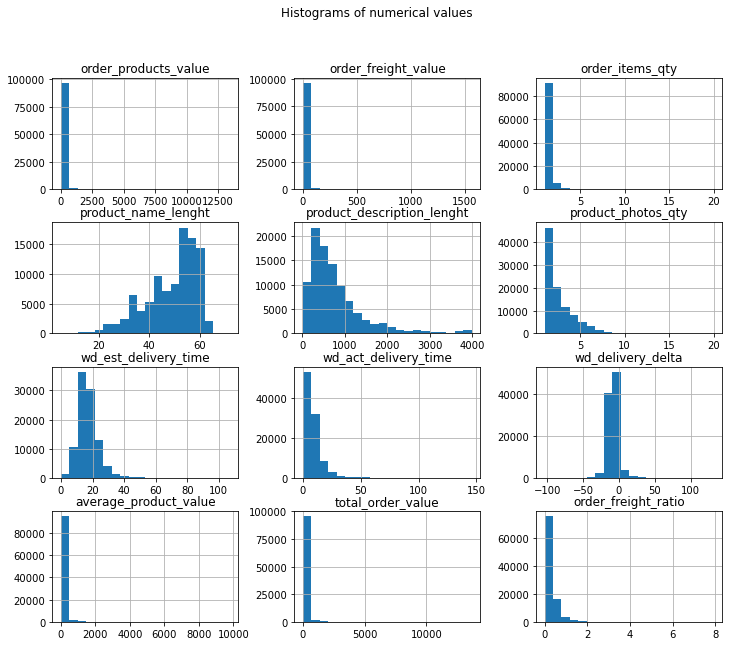

Skewness of numerical columns:


order_products_value          12.873680
order_freight_value           10.711127
order_items_qty                9.272915
product_name_lenght           -0.909036
product_description_lenght     2.071625
product_photos_qty             1.931065
wd_est_delivery_time           1.149350
wd_act_delivery_time           4.033003
wd_delivery_delta              2.006837
average_product_value          9.821760
total_order_value             12.219941
order_freight_ratio            3.745208
dtype: float64

In [19]:
num_columns = ['order_products_value', 'order_freight_value', 'order_items_qty',
               'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                'wd_est_delivery_time', 'wd_act_delivery_time', 'wd_delivery_delta', 'average_product_value', 'total_order_value', 'order_freight_ratio' ]

# Check all the numerical columns to determine if they are suffering from skewness
feat_eng_processed[num_columns].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns:")
feat_eng_processed[num_columns].skew()

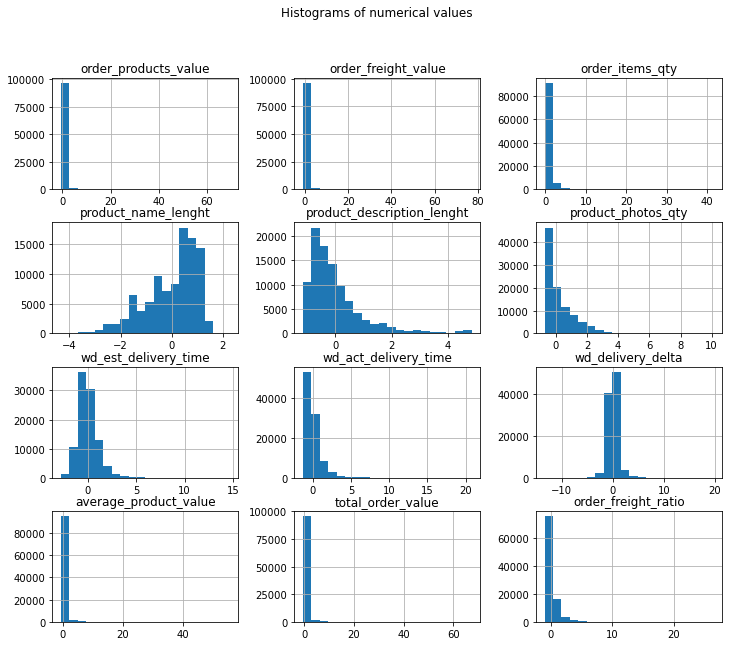

Skewness of numerical columns after applying log function:


<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.preprocessing import StandardScaler
feat_eng_processed[num_columns] = StandardScaler().fit_transform(feat_eng_processed[num_columns])

feat_eng_processed[num_columns].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns after applying log function:")
feat_eng_processed[num_columns].skew()
plt.tight_layout()

In [38]:
feat_model = feat_eng_processed.drop('order_id', axis=1)
feat_model.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,wd_est_delivery_time,wd_act_delivery_time,...,customer_state_18,customer_state_19,customer_state_20,customer_state_21,customer_state_22,customer_state_23,customer_state_24,customer_state_25,customer_state_26,late_1
0,1.158711,-0.393040,-0.219528,1,0.210058,-0.230292,-0.730628,5,2.102045,-0.843645,...,0,0,0,0,0,0,0,0,0,0
1,-0.462269,-0.323342,-0.219528,2,0.210058,-0.561360,-0.159373,5,-0.350652,-0.238030,...,0,0,0,0,0,0,0,0,0,0
2,-0.357607,-0.038530,-0.219528,1,-1.074049,1.334758,-0.730628,5,0.139887,0.216181,...,0,0,0,0,0,0,0,0,0,0
3,-0.253050,-0.538455,-0.219528,1,1.000278,-0.430437,0.411882,4,-1.331731,-0.692242,...,0,0,0,0,0,0,0,0,0,0
4,-0.362890,-0.498842,-0.219528,1,1.000278,-0.430437,-0.159373,4,-1.495244,-0.995049,...,0,0,0,0,0,0,0,1,0,0


In [39]:
# Create a 80/20 split & keep review_score distribution
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(feat_model, feat_model['review_score']):
    strat_train_set = feat_model.loc[train_index]
    strat_test_set = feat_model.loc[test_index]

In [40]:
# Better represents the origianl data 
strat_train_set['review_score'].value_counts()/len(strat_train_set['review_score'])

5    0.578515
4    0.195793
1    0.104724
3    0.087635
2    0.033332
Name: review_score, dtype: float64

In [45]:
# Sperating features and target
X_train = strat_train_set.drop('review_score', axis=1)
y_train = strat_train_set['review_score'].copy()

X_test = strat_test_set.drop('review_score', axis=1)
y_test = strat_test_set['review_score'].copy()

In [46]:
# Import KNeighborsClassifer
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf_KNN = KNeighborsClassifier()

# fit Classifer
clf_KNN.fit(X_train, y_train)

# Predict on the test set 

y_preds_KNN = clf_KNN.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

     class 1       0.42      0.37      0.39      2044
     class 2       0.12      0.03      0.05       650
     class 3       0.14      0.07      0.09      1711
     class 4       0.22      0.17      0.19      3821
     class 5       0.63      0.76      0.69     11290

    accuracy                           0.52     19516
   macro avg       0.30      0.28      0.28     19516
weighted avg       0.47      0.52      0.49     19516



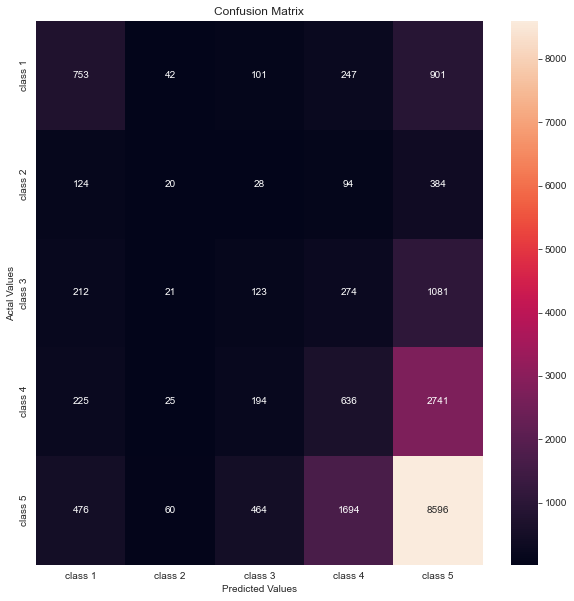

In [61]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

print('\nClassification Report:')
print(metrics.classification_report(y_test, y_preds_KNN, target_names=target_names))

cm = confusion_matrix(y_test, y_preds_KNN)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [62]:
# Import KNeighborsClassifer
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf_KNN = KNeighborsClassifier(weights='distance')

# fit Classifer
clf_KNN.fit(X_train, y_train)

# Predict on the test set 

y_preds_KNN = clf_KNN.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

     class 1       0.46      0.34      0.39      2044
     class 2       0.13      0.04      0.06       650
     class 3       0.17      0.08      0.11      1711
     class 4       0.23      0.15      0.18      3821
     class 5       0.63      0.81      0.70     11290

    accuracy                           0.54     19516
   macro avg       0.32      0.28      0.29     19516
weighted avg       0.47      0.54      0.49     19516



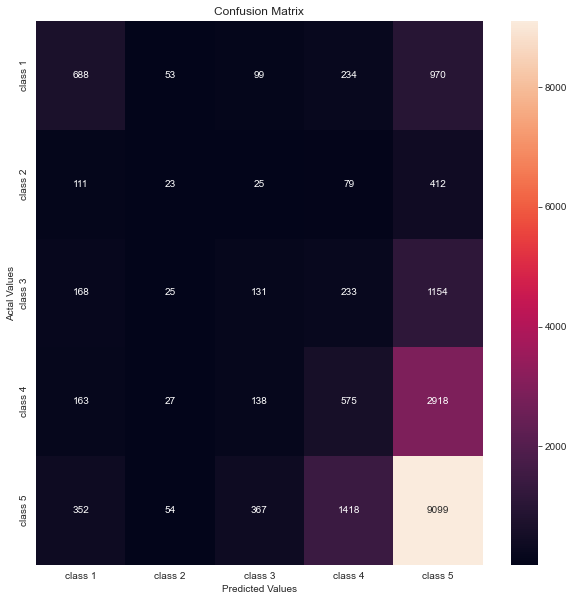

In [63]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

print('\nClassification Report:')
print(metrics.classification_report(y_test, y_preds_KNN, target_names=target_names))

cm = confusion_matrix(y_test, y_preds_KNN)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [64]:
# Instantiate DecisionTreeClassifier
clf_Decision_Tree = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# fit classifer
clf_Decision_Tree.fit(X_train, y_train)

# predict  on the test set 
y_preds_Decision_Tree = clf_Decision_Tree.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

     class 1       0.31      0.32      0.31      2044
     class 2       0.06      0.08      0.07       650
     class 3       0.11      0.12      0.11      1711
     class 4       0.22      0.22      0.22      3821
     class 5       0.63      0.61      0.62     11290

    accuracy                           0.44     19516
   macro avg       0.27      0.27      0.27     19516
weighted avg       0.45      0.44      0.45     19516



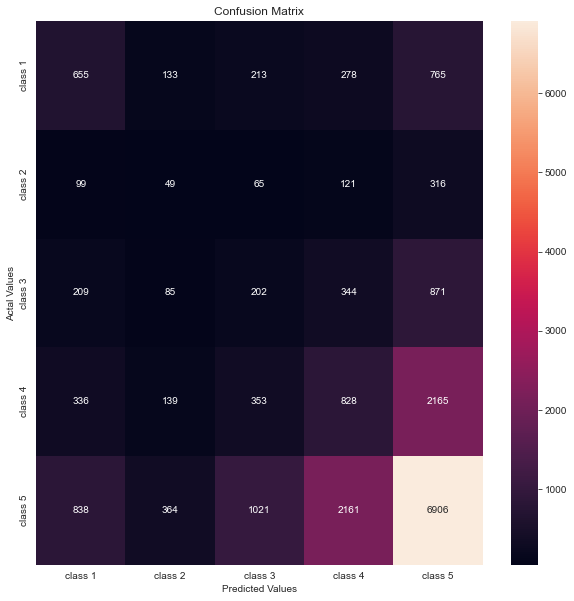

In [65]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

print('\nClassification Report:')
print(metrics.classification_report(y_test, y_preds_Decision_Tree, target_names=target_names))

cm = confusion_matrix(y_test, y_preds_Decision_Tree)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [69]:
# Instantiate RandomForestClassifier()
clf_RandomForestClassifier = RandomForestClassifier()

# fit classifer
clf_RandomForestClassifier.fit(X_train, y_train)

# predict  on the test set 
y_preds_RandomForestClassifier = clf_RandomForestClassifier.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

     class 1       0.58      0.39      0.47      2044
     class 2       0.26      0.02      0.04       650
     class 3       0.31      0.03      0.06      1711
     class 4       0.29      0.05      0.09      3821
     class 5       0.62      0.94      0.75     11290

    accuracy                           0.60     19516
   macro avg       0.41      0.29      0.28     19516
weighted avg       0.51      0.60      0.50     19516



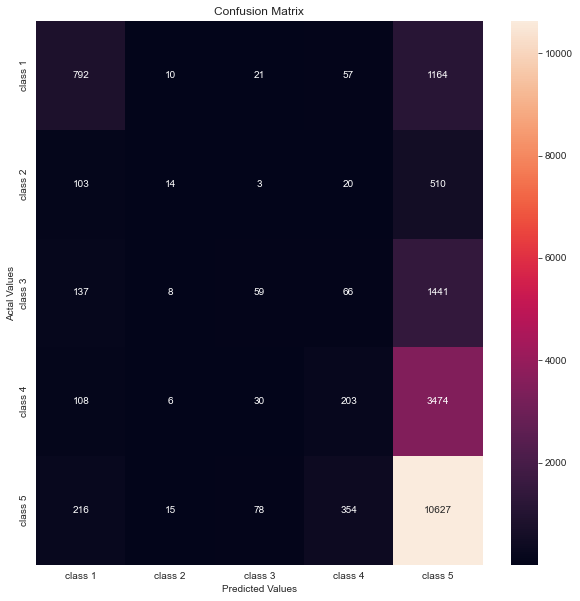

In [72]:
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']

print('\nClassification Report:')
print(metrics.classification_report(y_test, y_preds_RandomForestClassifier, target_names=target_names))

cm = confusion_matrix(y_test, y_preds_RandomForestClassifier)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [73]:
feat_eng_processed

,order_id,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,wd_est_delivery_time,...,customer_state_18,customer_state_19,customer_state_20,customer_state_21,customer_state_22,customer_state_23,customer_state_24,customer_state_25,customer_state_26,late_1
0,b95df3cef5297e79ef709ba256518f6f,1.158711,-0.393040,-0.219528,1,0.210058,-0.230292,-0.730628,5,2.102045,...,0,0,0,0,0,0,0,0,0,0
1,e98077a0d199a25a40eab3b14cc230d4,-0.462269,-0.323342,-0.219528,2,0.210058,-0.561360,-0.159373,5,-0.350652,...,0,0,0,0,0,0,0,0,0,0
2,8a723730400b508cbf47fbef4a76ec8e,-0.357607,-0.038530,-0.219528,1,-1.074049,1.334758,-0.730628,5,0.139887,...,0,0,0,0,0,0,0,0,0,0
3,cf71b9b6b7ed12d72f541b0420023f19,-0.253050,-0.538455,-0.219528,1,1.000278,-0.430437,0.411882,4,-1.331731,...,0,0,0,0,0,0,0,0,0,0
4,93ef9253c47e7dfc633c01f728488cb1,-0.362890,-0.498842,-0.219528,1,1.000278,-0.430437,-0.159373,4,-1.495244,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97573,cab08f0417a702d0f4782ec02356a4ac,-0.200745,-0.231079,-0.219528,1,-0.185052,-0.678738,0.411882,5,0.466914,...,0,0,0,0,0,0,0,0,0,0
97574,b99217b1fcf2fdeace7b8d869b76cb91,-0.462269,-0.578067,-0.219528,2,-1.074049,-0.918010,-0.730628,5,0.139887,...,0,0,0,0,0,0,0,1,0,0
97575,f7ddb35c9c7bc33ff949a8808e2818fc,-0.096083,-0.637737,-0.219528,1,-0.086275,-0.436457,1.554393,5,-1.004705,...,0,0,0,0,0,0,0,1,0,0
97576,bede3503afed051733eeb4a84d1adcc5,-0.148388,-0.312310,-0.219528,1,-0.086275,-0.477088,0.983137,1,-0.187139,...,0,0,0,0,0,0,0,0,0,0


In [100]:
clusteringData.head()

,customer_unique_id,total_orders,total_spent,recency,class_recency,class_total_spent,class_total_orders,customerSegment
85154,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,4,3,1,Potential Loyslist
46123,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,118,4,1,1,Potential Loyslist
79231,0000f46a3911fa3c0805444483337064,1,69.00,541,1,2,1,Hibernating
74925,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,325,2,1,1,About to Sleep
73751,0004aac84e0df4da2b147fca70cf8255,1,180.00,292,3,4,1,Potential Loyslist


In [140]:
feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97578 entries, 0 to 97577
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97578 non-null  object 
 1   order_status                   97578 non-null  object 
 2   order_products_value           97578 non-null  float64
 3   order_freight_value            97578 non-null  float64
 4   order_items_qty                97578 non-null  int64  
 5   order_sellers_qty              97578 non-null  int64  
 6   customer_id                    97578 non-null  object 
 7   customer_state                 97578 non-null  object 
 8   product_name_lenght            97578 non-null  int64  
 9   product_description_lenght     97578 non-null  int64  
 10  product_photos_qty             97578 non-null  int64  
 11  review_score                   97578 non-null  int64  
 12  product_category_name_english  97578 non-null 

In [141]:
class FeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        
        
        df['wd_est_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_estimated_delivery_date), axis=1)
        df['wd_act_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_delivered_customer_date), axis=1)
        df['wd_delivery_delta'] = df.wd_act_delivery_time - df.wd_est_delivery_time
        
        df['late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        df['average_product_value'] = df.order_products_value/df.order_items_qty
        
        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
        
       # cols2drop = ['order_purchase_timestamp', 'order_aproved_at',
                     #'order_estimated_delivery_date', 'order_delivered_customer_date']
        #df.drop(cols2drop, axis=1, inplace=True)
        # Day of the week feature creation
        df['day_of_wk'] = df.order_approved_at.dt.weekday
        
        # Last order date(Recency)
        last_order = df.order_purchase_timestamp.max()
        df['recency'] = ((last_order - df['order_purchase_timestamp']).dt.days)

        # Frequency of purchases feature creation - how many unique orders does each customer have(Frequency)
        df['total_orders'] = data.groupby('customer_id')['order_id'].transform('nunique')

        # Total Spent feature creation(Monetaray)
        df['total_spent'] = data.groupby('customer_id')['price'].transform('sum')
        
        return df

In [142]:
attr_adder = FeaturesAdder()
feat_eng_v2 = attr_adder.transform(order_list)
feat_eng_v2.head(3)

AttributeError: 'DataFrame' object has no attribute 'order_approved_at'

In [ ]:
# Feature creation

# Day of the week feature creation
data['day_of_wk'] = feat_eng.order_approved_at.dt.weekday

# Last order date(Recency)
last_order = data.order_purchase_timestamp.max()
data['recency'] = ((last_order - data['order_purchase_timestamp']).dt.days)

# Frequency of purchases feature creation - how many unique orders does each customer have(Frequency)
data['total_orders'] = data.groupby('customer_unique_id')['order_id'].transform('nunique')

# Total Spent feature creation(Monetaray)
data['total_spent'] = data.groupby('customer_unique_id')['price'].transform('sum')

## Buisness Problem

- Need to address serious negative reviews
- Need to predict customer satisfaction
- To predict review(+VE or -VE) of a customer on thier next purchase, given historical data. 